In [1]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report
from src.utils.model import load_experiment,load_exprerimant_by_id
import torch
from src.experiments.static_quantization import quantize_static
from src.experiments.pruning import model_size
sns.set(color_codes=True)
%matplotlib inline
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
%load_ext autoreload
%autoreload 2

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"
MODEL = "resnet18"


In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mt = torch.FloatTensor(mean).view(3,1,1)
st = torch.FloatTensor(std).view(3,1,1)

def unnormalize(img):
    return img * st + mt


In [3]:
experiments = [
    {'id': "10", 'train_id': "3", 'name': 'resnet18' }, 
    {'id': "7", 'train_id': "7", 'name': 'lenet' }, 
    {'id': "11", 'name': 'lenetplus' },
    {'id': "14", 'train_id': "8", 'name': 'squeezenet' }, 
]
exp = [m  for m in experiments if m["name"] == MODEL][0]

In [4]:
d = mlflow.search_runs(
    experiment_ids=exp["id"],
    output_format="pandas",
)
if 'train_id' in exp.keys():
    d2 = mlflow.search_runs(
        experiment_ids=exp["train_id"],
        output_format="pandas",
    )
    d = pd.concat([d, d2])

In [5]:
q = d[d["tags.type"] == "quantization"]
q = q[q[AP] == "7"]
q = q[q[WP] == "8"].iloc[0]

pq = d[d["tags.type"] == "pruning + quantization"]
pq = pq[pq[AP] == "7"]
pq = pq[pq[WP] == "8"].iloc[0]

train = d[d["tags.stage"] == "train"].iloc[0]
t_model, datamodule, _ = load_experiment(train["params.hydra/log_dir"])

prun = d[d["tags.pruning_method"] == 'unstructured_l1']
prun = prun[prun["tags.type"] == 'pruning'].iloc[0]
cp = prun["params.model_0.25"]   
if not cp:
    raise Error()
p_model, datamodule, _ = load_experiment(train["params.hydra/log_dir"], compressed_path=cp)

t_model.eval()
q_model = quantize_static(t_model, datamodule.test_dataloader())
#qp_model = quantize_static(p_model, datamodule.test_dataloader())


Global seed set to 42
Global seed set to 42
QConfig(activation=functools.partial(<class 'torch.quantization.observer.MovingAverageMinMaxObserver'>, dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine), weight=functools.partial(<class 'torch.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_affine))


In [6]:
def saliency(input, model):
    device = torch.device("cpu:0")
    model.to(device)
    input.to(device)

    for param in model.parameters():
        param.requires_grad = False
    
    input = input.reshape((1,3,32,32))
    model.eval()


    input.requires_grad = True
    preds = model(input)
    score, indices = torch.max(preds, 1)
    # backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    # get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    # normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    return slc.numpy()

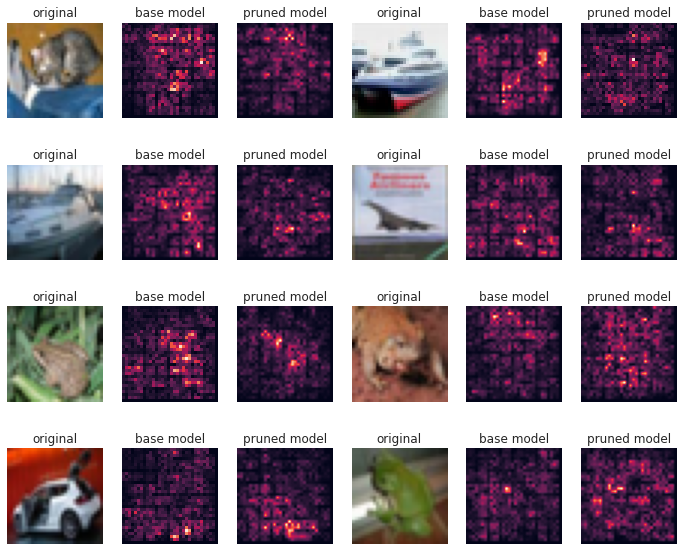

In [89]:
test = datamodule.data_test
image = next(iter(test))[0]

fig = plt.figure(figsize=(12,10))

i = 1
for image, _ in iter(test):
    if i <= 8:
        slc = saliency(image, t_model)
        slc_p = saliency(image, p_model)


        img = unnormalize(image)
        img = img.numpy()
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)

        plt.subplot(4,6, 3*i-2)
        plt.axis('off')
        plt.title("original")
        plt.imshow(img)
        

        plt.subplot(4,6, 3*i-1)
        plt.axis('off')
        plt.title("base model")
        plt.imshow(slc)

        plt.subplot(4,6, 3*i)
        plt.axis('off')
        plt.title("pruned model")
        plt.imshow(slc_p)
    i += 1
plt.savefig(f'/home/k.schwienbacher/quantization-robustness/data/saliency/s-{MODEL}-pfp.jpg')

In [7]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def grad_cam(input, model, target_layer):
    image, target = input
    rgb_image = unnormalize(image).numpy()
    rgb_image = rgb_image.swapaxes(0,1)
    rgb_image = rgb_image.swapaxes(1,2)

    cam = GradCAM(model=model, target_layer=target_layer, use_cuda=False)

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=image.reshape((1,3,32,32)), target_category=target)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_image, grayscale_cam)

    return visualization

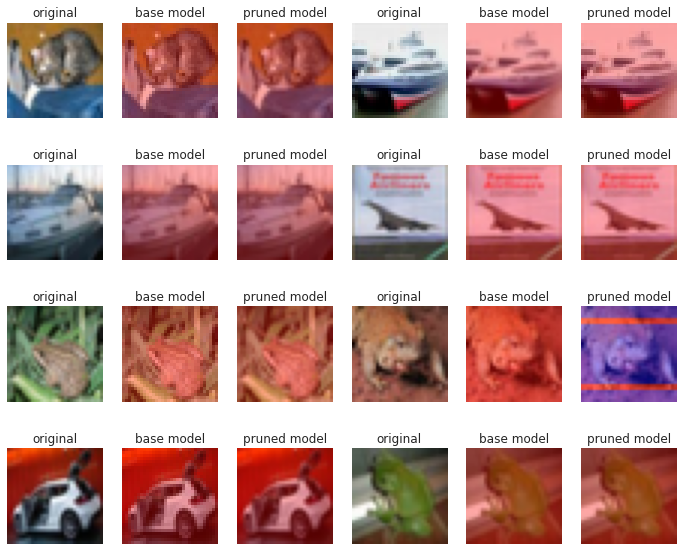

In [9]:
test = datamodule.data_test
image = next(iter(test))[0]

fig = plt.figure(figsize=(12,10))

i = 1
for input in iter(test):
    if i <= 8:
        image, target = input
        slc = grad_cam(input, t_model, t_model.model.layer4[-1])
        slc_p = grad_cam(input, p_model, p_model.model.layer4[-1])

        img = unnormalize(image)
        img = img.numpy()
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)

        plt.subplot(4,6, 3*i-2)
        plt.axis('off')
        plt.title("original")
        plt.imshow(img)
        

        plt.subplot(4,6, 3*i-1)
        plt.axis('off')
        plt.title("base model")
        plt.imshow(slc)

        plt.subplot(4,6, 3*i)
        plt.axis('off')
        plt.title("pruned model")
        plt.imshow(slc_p)
    i += 1
plt.savefig(f'/home/k.schwienbacher/quantization-robustness/data/saliency/g-{MODEL}.jpg')